Компоненты: метан, этан, пропан

Состав жидкой фазы:
n_1: 0.2999
n_2: 0.2999
n_3: 0.4001

Состав паровой фазы:
n_1: 0.2999
n_2: 0.2999
n_3: 0.4001


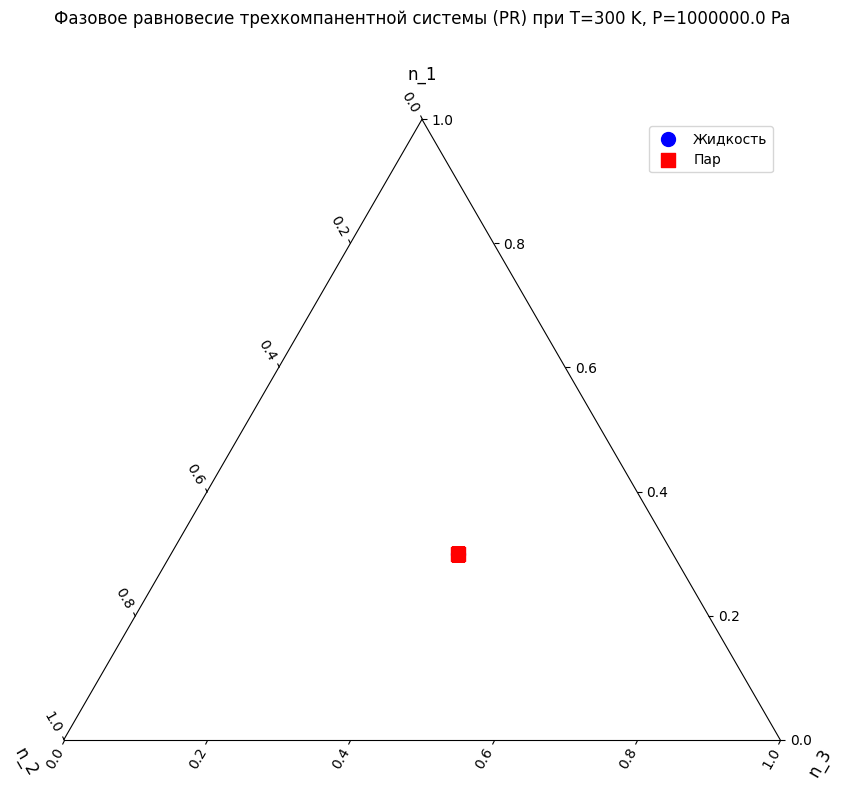

In [15]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import mpltern

class EquilState:
    def __init__(self, comp, P_pas, T_k):
        self.components = components
        self.P = P_pas
        self.T = T_k
        self.R = 8.314
        
        # парам ур сост для компонетн (кр. давл и темп + ац.факт(через ф. 1.34 доб.расчет))
        # доб.вынести запрос вх.дан в конс
        self.component_param = {
            'n_1': {'Tc': 190.6, 'Pc': 46.0 * 1e5, 'omega': 0.011},
            'n_2': {'Tc': 305.3, 'Pc': 48.8 * 1e5, 'omega': 0.099},
            'n_3': {'Tc': 369.8, 'Pc': 42.5 * 1e5, 'omega': 0.152}
        }
        
        # Параметры бинарного взаимодействия (kij)
        self.kij = np.zeros((3, 3))
        np.fill_diagonal(self.kij, 0)
        
        self.ai = np.zeros(3)
        self.bi = np.zeros(3)
        self.mi = np.zeros(3)
        
        self.alpha_i = np.zeros(3)
        self.Coeff_PR()

    # коэф в PR (бр + канд)
    def Coeff_PR(self):
        for i, comp in enumerate(self.components):
            params = self.component_param[comp]
            Tc = params['Tc']
            Pc = params['Pc']
            omega = params['omega']
            
            self.ai[i] = 0.45724 * (self.R**2 * Tc**2) / Pc
            self.bi[i] = 0.0778 * self.R * Tc / Pc

            if omega <= 0.49:
                self.mi[i] = 0.37464 + 1.54226 * omega - 0.26992 * omega**2
            else:
                self.mi[i] = 0.3796 + 1.485 * omega - 0.1644 * omega**2 + 0.01667 * omega**3
            
            self.alpha_i[i] = (1 + self.mi[i] * (1 - np.sqrt(self.T / Tc)))**2

    #параметры смешения?! (без с (бр 4.37 + 4.38) c c??)
    def Mix_param(self, z, phase):
        A = 0
        B = 0
        
        for i in range(3):
            for j in range(3):
                A += z[i] * z[j] * np.sqrt(self.ai[i]*self.ai[j]) * (1 - self.kij[i,j])
        
        B = np.sum(z * self.bi)
        
        return A, B

    #ур сост PR (канд 1.29)
    def PR_eq(self, V, a, b):
        return (self.P * V**3 - 
                (self.R * self.T - self.P * b) * V**2 + 
                (a - 2 * self.R * self.T * b - 3 * self.P * b**2) * V - 
                (a * b - self.R * self.T * b**2 - self.P * b**3))

    #реш ур-ния
    def Solve_eq(self, a, b):
        coeffs = [
            self.P,
            -(self.R * self.T - self.P * b),
            (a - 2 * self.R * self.T * b - 3 * self.P * b**2),
            -(a * b - self.R * self.T * b**2 - self.P * b**3)
        ]
        
        roots = np.roots(coeffs)
        real_roots = np.real(roots[np.isreal(roots)])
        pos_roots = real_roots[real_roots > 0]
        
        return pos_roots

    #летучесть
    def Phi(self, z, phase):
        A, B = self.Mix_param(z, phase)
        roots = self.Solve_eq(A, B)
        
        if phase == 'liq':
            V = np.min(roots)
        else:
            V = np.max(roots)
        
        phi = np.zeros(3)
        
        for i in range(3):
            summ = 0
            for j in range(3):
                summ += z[j] * np.sqrt(self.ai[i] * self.ai[j]) * (1 - self.kij[i,j])
            
            AA = A * self.P / (self.R * self.T)**2
            BB = B * self.P / (self.R * self.T)
            Z = self.P * V / (self.R * self.T)
            
            t1 = self.bi[i] / B * (Z - 1)
            t2 = -np.log(Z - BB)
            t3 = -AA / (2 * np.sqrt(2) * BB) * (2 * summ / A - self.bi[i] / B) * np.log((Z + (1 + np.sqrt(2)) * BB)/(Z + (1 - np.sqrt(2)) * BB))
            
            phi[i] = np.exp(t1 + t2 + t3)
        
        return phi

    #условия равн
    def Equil_cond(self, z):
        z_liq = np.array([z[0], z[1], 1 - z[0] - z[1]])
        z_vap = np.array([z[2], z[3], 1 - z[2] - z[3]])
        
        phi_liq = self.Phi(z_liq, 'liq')
        phi_vap = self.Phi(z_vap, 'vap')
        
        f_liq = z_liq * phi_liq * self.P
        f_vap = z_vap * phi_vap * self.P
        
        return np.sum((f_liq - f_vap)**2)

    #ура...ищем равновесие
    def Equil(self):
        z0 = np.array([0.3, 0.3, 0.3, 0.3])

        # сумма <= 1, комп >=0
        constraints = (
            {'type': 'ineq', 'fun': lambda z: 1 - z[0] - z[1]},
            {'type': 'ineq', 'fun': lambda z: 1 - z[2] - z[3]},
            {'type': 'ineq', 'fun': lambda z: z[0]},
            {'type': 'ineq', 'fun': lambda z: z[1]},
            {'type': 'ineq', 'fun': lambda z: z[2]},
            {'type': 'ineq', 'fun': lambda z: z[3]}
        )
        
        result = minimize(self.Equil_cond, z0, 
                         constraints=constraints,
                         method='SLSQP',
                         options={'maxiter': 1000})
        
        if result.success:
            z_liq = np.array([result.x[0], result.x[1], 1 - result.x[0] - result.x[1]])
            z_vap = np.array([result.x[2], result.x[3], 1 - result.x[2] - result.x[3]])
            return z_liq, z_vap
        else:
            raise ValueError("Нет решений :(")

    #...попытка красивой картинки
    def plot_tr(self, z_liq, z_vap):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='ternary')
        
        ax.set_title(f"Фазовое равновесие трехкомпанентной системы (PR) при T={self.T} K, P={self.P} Pa", pad=30)
        ax.set_tlabel(self.components[0], fontsize=12)
        ax.set_llabel(self.components[1], fontsize=12)
        ax.set_rlabel(self.components[2], fontsize=12)
        
        ax.scatter([z_liq[0]], [z_liq[1]], [z_liq[2]], 
                  marker='o', color='blue', s=100, label='Жидкость')
        ax.scatter([z_vap[0]], [z_vap[1]], [z_vap[2]], 
                  marker='s', color='red', s=100, label='Пар')
        
        ax.plot([z_liq[0], z_vap[0]], [z_liq[1], z_vap[1]], [z_liq[2], z_vap[2]], 
               color='gray', linestyle='--', linewidth=1)
        
        ax.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    
    components = ['n_1', 'n_2', 'n_3']

    #Условия на Т и Р
    P = 10.0 * 1e5
    T = 300 

    print('Компоненты: метан, этан, пропан\n')
    
    search = EquilState(components, P, T)
    
    try:
        z_liq, z_vap = search.Equil()
        
        print("Состав жидкой фазы:")
        for name, z in zip(components, z_liq):
            print(f"{name}: {z:.4f}")
            
        print("\nСостав паровой фазы:")
        for name, z in zip(components, z_vap):
            print(f"{name}: {z:.4f}")
        
        search.plot_tr(z_liq, z_vap)
        
    except ValueError as e:
        print(e)